In [1]:
#import packages
import isotopylog as ipl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.optimize import fsolve, minimize

# 读取CSV文件
df = pd.read_csv('./datasets/Thermal_History_Hu.csv')

# 提取四个变量
time = df['Time/Myr'].values
avg_temp = df['Avg_T/Celsius'].values + 273.15
min_temp = df['Min_T/Celsius'].values + 273.15
max_temp = df['Max_T/Celsius'].values + 273.15

# 查看提取的变量
print(time[:5], avg_temp[:5], min_temp[:5], max_temp[:5])

[0.  0.5 1.  1.5 2. ] [318.15 318.33 318.51 318.69 318.87] [315.9   316.071 316.242 316.413 316.584] [320.4   320.589 320.778 320.967 321.156]


In [2]:
# 读取CSV文件
df_test = pd.read_csv('./datasets/acutal_test_Hu.csv')

# 提取四个变量
delta47 = df_test['Delta47'].values
delta47_err = df_test['SD'].values

# 查看提取的变量
print(delta47[:5], delta47_err[:5])

[0.3   0.292 0.277 0.334 0.483] [0.0101  0.0266  0.00896 0.0142  0.006  ]


In [3]:
def constrained_u_fit(time, values, start_x, end_x, new_max_temp, plot=False):
    """
    拟合带约束的倒转U型四次多项式曲线，确保端点值、端点导数连续，中点最大值，并平滑过渡。
    
    参数:
    - time: np.ndarray, x坐标数组
    - values: np.ndarray, 原始数据的y值
    - start_x: float, 区间的起始x值
    - end_x: float, 区间的结束x值
    - new_max_temp: float, 目标最大温度值
    - plot: bool, 是否绘制结果图像
    
    返回:
    - adjusted_values: np.ndarray, 调整后的整体数据数组
    """
    # 提取局部区间的数据
    mask = (time >= start_x) & (time <= end_x)
    local_time = time[mask]
    local_values = values[mask]

    # 获取起点、终点的值
    start_value = local_values[0]
    end_value = local_values[-1]
    mid_x = (start_x + end_x) / 2  # 极值点
    start_slope = (local_values[1] - local_values[0]) / (local_time[1] - local_time[0])  # 近似起点斜率

    # 定义四次多项式及其导数
    def polynomial(x, a, b, c, d, e):
        return a * x**4 + b * x**3 + c * x**2 + d * x + e

    def polynomial_derivative(x, a, b, c, d):
        return 4 * a * x**3 + 3 * b * x**2 + 2 * c * x + d

    # 定义约束方程
    def constraints(params):
        a, b, c, d, e = params
        eq1 = polynomial(start_x, a, b, c, d, e) - start_value           # 起点值
        eq2 = polynomial_derivative(start_x, a, b, c, d) - start_slope   # 起点斜率
        eq3 = polynomial(end_x, a, b, c, d, e) - end_value               # 终点值
        eq4 = polynomial(mid_x, a, b, c, d, e) - new_max_temp            # 中点最大值
        eq5 = polynomial_derivative(mid_x, a, b, c, d)                   # 中点处导数为0
        return [eq1, eq2, eq3, eq4, eq5]

    # 求解四次多项式系数
    initial_guess = [0, 0, 0, start_slope, start_value]
    params = fsolve(constraints, initial_guess)
    a, b, c, d, e = params

    # 生成拟合曲线
    adjusted_local_values = polynomial(local_time, a, b, c, d, e)

    # 拼接数据
    adjusted_values = values.copy()
    adjusted_values[mask] = adjusted_local_values

    # 绘图
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(time, values, label='Original Curve', color='red', linewidth=1.5)
        plt.plot(local_time, adjusted_local_values, label='Adjusted U-shaped Curve', color='blue', linewidth=2)
        plt.scatter(mid_x, new_max_temp, color='orange', s=100, label='New Top Point (%.2f, %.2f)' % (mid_x, new_max_temp))
        plt.axvline(x=start_x, color='gray', linestyle='--', label='Region Start')
        plt.axvline(x=end_x, color='gray', linestyle='--', label='Region End')
        plt.xlabel('Time (Myr)')
        plt.ylabel('Temperature')
        plt.legend()
        plt.title('Smooth U-shaped Curve with Endpoint and Slope Constraints')
        plt.show()

    return adjusted_values

f:\Anaconda3\envs\clump\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


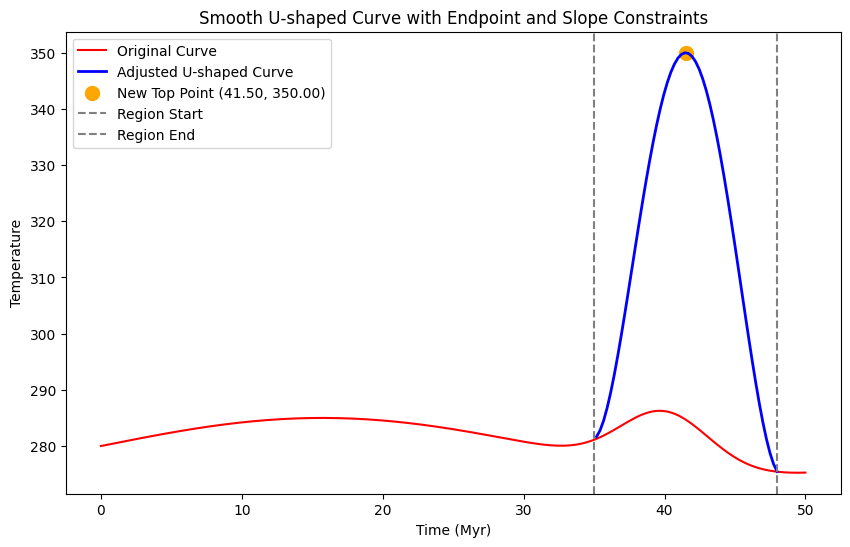

In [4]:
# 示例数据
time_ex = np.linspace(0, 50, 200)
values_ex = 280 + 5 * np.sin(0.1 * time_ex) + 10 * np.exp(-0.05 * (time_ex - 40) ** 2)  # 模拟数据

# 调用函数
start_x = 35
end_x = 48
new_max_temp = 350  # 目标最大温度值
adjusted_values = constrained_u_fit(time_ex, values_ex, start_x, end_x, new_max_temp, plot=True)

In [5]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'calcite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
#start_time = 35
#end_time = 48
#new_max_temp = 100 + 273.5  # 目标最大温度值
#T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = avg_temp[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

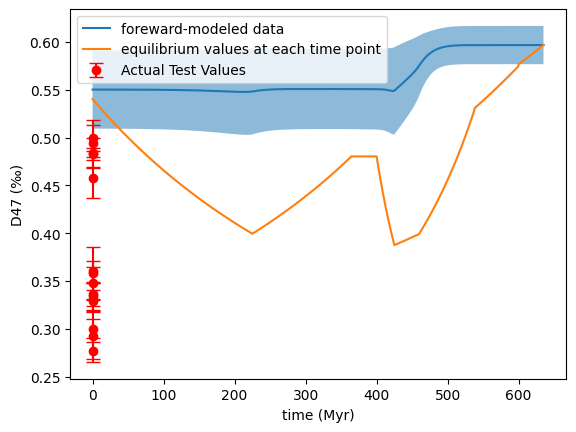

In [6]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

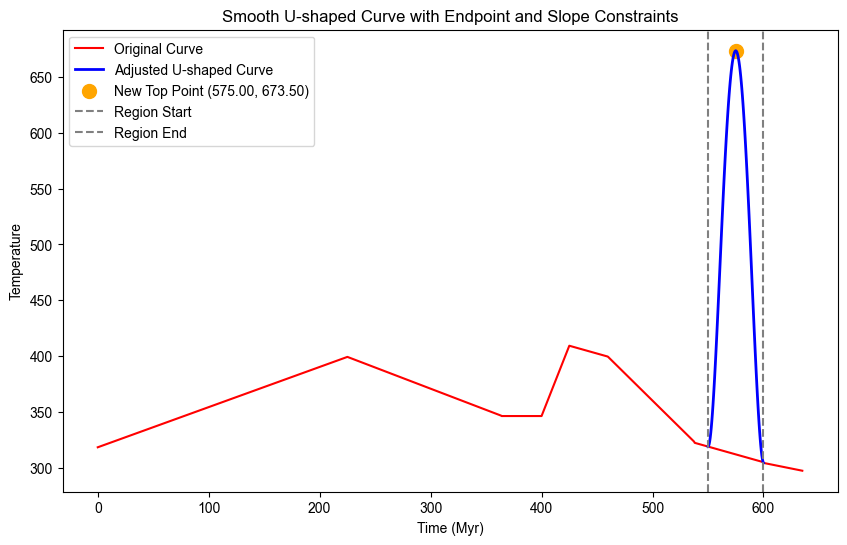

In [14]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'calcite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 550
end_time = 600
new_max_temp = 400 + 273.5  # 目标最大温度值
T_400_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp, plot=True)

T = T_400_avg[::-1]
#make D0 in equilibrium
D0 = ipl.Deq_from_T(T[0])
d0 = [D0, 0, 0] #still d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 #convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1]#原始时间尺度为Myr

#now calculate D at each time point
D, Dstd = ipl.geologic_history(tSecond, T, ed, d0, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq = ipl.Deq_from_T(T)

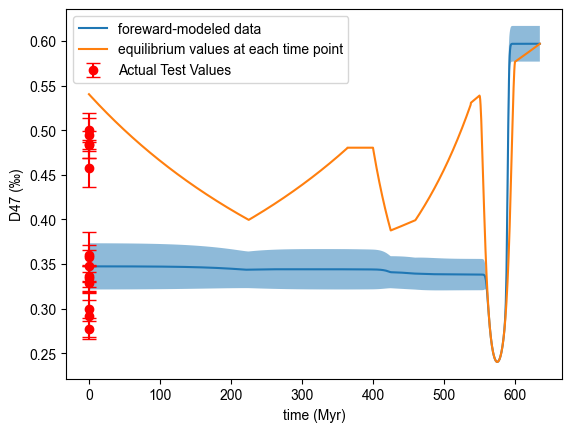

In [15]:
fig,ax = plt.subplots(1,1)
ax.plot(tmyr, D, label = 'foreward-modeled data')
ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha = 0.5)
ax.errorbar([0] * len(delta47), delta47, yerr=delta47_err, fmt='o', label='Actual Test Values', color='red', capsize=5)
ax.plot(tmyr,Deq, label = 'equilibrium values at each time point')

ax.set_xlabel('time (Myr)')
ax.set_ylabel('D47 (‰)')
ax.legend(loc = 'best')

In [10]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'calcite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 550
end_time = 600

new_max_temp_150 = 150 + 273.5
new_max_temp_160 = 160 + 273.5
new_max_temp_170 = 170 + 273.5
new_max_temp_180 = 180 + 273.5
new_max_temp_190 = 190 + 273.5
new_max_temp_200 = 200 + 273.5

T_150_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_150, plot=False)
T_160_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_160, plot=False)
T_170_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_170, plot=False)
T_180_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_180, plot=False)
T_190_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_190, plot=False)
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_200, plot=False)

#T_ini = avg_temp[::-1]
#make D0 in equilibrium
#D0_ini = ipl.Deq_from_T(avg_temp[0])
#d0_ini = [D0_ini, 0, 0] # d13C and d18O of zero

T_150 = T_150_avg[::-1]
#make D0 in equilibrium
D0_150 = ipl.Deq_from_T(T_150[0])
d0_150 = [D0_150, 0, 0] # d13C and d18O of zero

T_160 = T_160_avg[::-1]
#make D0 in equilibrium
D0_160 = ipl.Deq_from_T(T_160[0])
d0_160 = [D0_160, 0, 0] # d13C and d18O of zero

T_170 = T_170_avg[::-1]
#make D0 in equilibrium
D0_170 = ipl.Deq_from_T(T_170[0])
d0_170 = [D0_170, 0, 0] # d13C and d18O of zero

T_180 = T_180_avg[::-1]
#make D0 in equilibrium
D0_180 = ipl.Deq_from_T(T_180[0])
d0_180 = [D0_180, 0, 0] # d13C and d18O of zero

T_190 = T_190_avg[::-1]
#make D0 in equilibrium
D0_190 = ipl.Deq_from_T(T_190[0])
d0_190 = [D0_190, 0, 0] # d13C and d18O of zero

T_200 = T_200_avg[::-1]
#make D0 in equilibrium
D0_200 = ipl.Deq_from_T(T_200[0])
d0_200 = [D0_200, 0, 0] # d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 # convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1] # original time scale is Myr

#now calculate D at each time point
#D_ini, Dstd_ini = ipl.geologic_history(tSecond, T_ini, ed, d0_ini, d0_std = d0_std)
D_150, Dstd_150 = ipl.geologic_history(tSecond, T_150, ed, d0_150, d0_std = d0_std)
D_160, Dstd_160 = ipl.geologic_history(tSecond, T_160, ed, d0_160, d0_std = d0_std)
D_170, Dstd_170 = ipl.geologic_history(tSecond, T_170, ed, d0_170, d0_std = d0_std)
D_180, Dstd_180 = ipl.geologic_history(tSecond, T_180, ed, d0_180, d0_std = d0_std)
D_190, Dstd_190 = ipl.geologic_history(tSecond, T_190, ed, d0_190, d0_std = d0_std)
D_200, Dstd_200 = ipl.geologic_history(tSecond, T_200, ed, d0_200, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
#Deq_ini = ipl.Deq_from_T(T_ini)
Deq_150 = ipl.Deq_from_T(T_150_avg)
Deq_160 = ipl.Deq_from_T(T_160_avg)
Deq_170 = ipl.Deq_from_T(T_170_avg)
Deq_180 = ipl.Deq_from_T(T_180_avg)
Deq_190 = ipl.Deq_from_T(T_190_avg)
Deq_200 = ipl.Deq_from_T(T_200_avg)

f:\Anaconda3\envs\clump\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


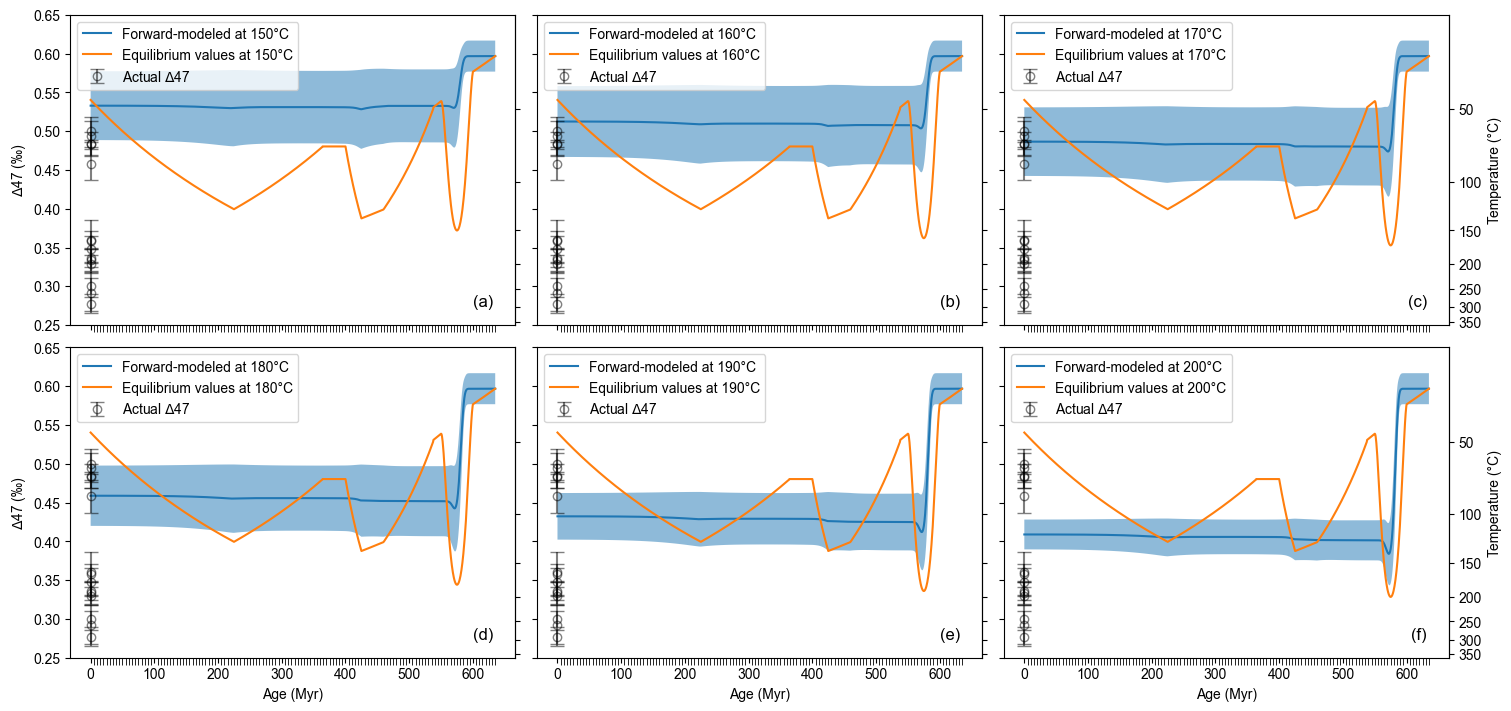

In [11]:
plt.rcParams["font.family"] = "Arial"  # 设置全局字体为 Arial

# =========================
# 全局：主y轴范围（Δ47）
# =========================
ymin, ymax = 0.15, 0.68

# =========================
# 预先计算：右侧温度轴的 tick 位置（一次算好，所有子图复用）
# =========================
d47_map = np.linspace(ymin, ymax, 600)
T_map = np.array([ipl.T_from_Deq(d) - 273.15 for d in d47_map], dtype=float)  # °C

mask = np.isfinite(T_map)
d47_map = d47_map[mask]
T_map = T_map[mask]

Tmin, Tmax = float(np.min(T_map)), float(np.max(T_map))

tick_step = 50  # 每隔 10°C 一个刻度（你原来就是这个）
tick_start = np.floor(Tmin / tick_step) * tick_step
tick_end   = np.ceil(Tmax / tick_step) * tick_step
T_ticks = np.arange(tick_start, tick_end + 0.1, tick_step)

# 每个温度刻度找到最接近的 Δ47 位置
pairs = []
for T in T_ticks:
    idx = int(np.abs(T_map - T).argmin())
    pairs.append((float(d47_map[idx]), int(round(T))))

# 去重（可能会出现多个温度映射到同一个Δ47点），并按Δ47从小到大排序
tmp = {}
for d, T in pairs:
    tmp[d] = T
pairs_sorted = sorted(tmp.items(), key=lambda x: x[0])

d47_ticks = [d for d, T in pairs_sorted]
T_labels  = [f"{T}" for d, T in pairs_sorted]

# =========================
# 作图
# =========================
fig, axes = plt.subplots(
    2, 3, figsize=(15, 7),
    sharex=True, sharey=True,
    constrained_layout=True
)

temperatures = [150, 160, 170, 180, 190, 200]
data = [
    (D_150, Dstd_150, Deq_150),
    (D_160, Dstd_160, Deq_160),
    (D_170, Dstd_170, Deq_170),
    (D_180, Dstd_180, Deq_180),
    (D_190, Dstd_190, Deq_190),
    (D_200, Dstd_200, Deq_200)
]

for i, (temp, ax, (D, Dstd, Deq)) in enumerate(zip(temperatures, axes.flatten(), data)):
    ax.plot(tmyr, D, label=f'Forward-modeled at {temp}°C')
    ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha=0.5)
    ax.plot(tmyr, Deq[::-1], label=f'Equilibrium values at {temp}°C')

    ax.errorbar(
        [0] * len(delta47),
        delta47, yerr=delta47_err,
        fmt='o',
        label='Actual $\Delta$47',
        color='black',
        capsize=5,
        alpha=0.5,
        markerfacecolor='none'
    )

    ax.set_ylim(ymin, ymax)

    if i >= 3:
        ax.set_xlabel('Age (Myr)')
    if i % 3 == 0:
        ax.set_ylabel('$\Delta$47 (‰)')

    # ========== 右侧 secondary y-axis：Temperature ==========
    secax = ax.secondary_yaxis('right')
    secax.set_yticks(d47_ticks)

    if i % 3 == 2:  # 仅每行最右侧显示数字
        secax.set_yticklabels(T_labels)
        secax.set_ylabel('Temperature (°C)')
    else:
        secax.tick_params(labelright=False)  # 不显示数字（保留刻度线）

    # ========== minor ticks（只画短刻度线，不显示数字） ==========
    ax.set_xticks(np.arange(0, np.max(tmyr) + 1, 5), minor=True)
    ax.set_yticks(np.arange(ymin, ymax + 1e-9, 0.05), minor=True)
    ax.tick_params(axis='x', which='minor', length=5)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.set_ylim(0.25, 0.65)

    # 子图标签
    ax.text(
        0.95, 0.05, f'({chr(97 + i)})',
        transform=ax.transAxes,
        fontsize=12,
        va='bottom', ha='right'
    )

    ax.legend(loc='best')

# 保存
try:
    fig.savefig("output_figure_hu_lowT.svg", format="svg")
    fig.savefig("output_figure_hu_lowT.pdf", format="pdf")
except Exception as e:
    print(f"Error in saving figures: {e}")

plt.show()

In [30]:
#generate EDistribution instance from literature
ed = ipl.EDistribution.from_literature(
        mineral = 'calcite',
        reference = 'HH21')

#define the initial composition and the time-temperature evolutions
d0_std = [0.02]

#zoom the max thermal peaks
start_time = 550
end_time = 600

new_max_temp_100 = 100 + 273.5
new_max_temp_150 = 150 + 273.5
new_max_temp_200 = 200 + 273.5
new_max_temp_250 = 250 + 273.5
new_max_temp_300 = 300 + 273.5
new_max_temp_350 = 350 + 273.5

T_100_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_100, plot=False)
T_150_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_150, plot=False)
T_200_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_200, plot=False)
T_250_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_250, plot=False)
T_300_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_300, plot=False)
T_350_avg = constrained_u_fit(time, avg_temp, start_time, end_time, new_max_temp_350, plot=False)

T_ini = avg_temp[::-1]
#make D0 in equilibrium
D0_ini = ipl.Deq_from_T(avg_temp[0])
d0_ini = [D0_ini, 0, 0] # d13C and d18O of zero

T_100 = T_100_avg[::-1]
#make D0 in equilibrium
D0_100 = ipl.Deq_from_T(T_100[0])
d0_100 = [D0_100, 0, 0] # d13C and d18O of zero

T_150 = T_150_avg[::-1]
#make D0 in equilibrium
D0_150 = ipl.Deq_from_T(T_150[0])
d0_150 = [D0_150, 0, 0] # d13C and d18O of zero

T_200 = T_200_avg[::-1]
#make D0 in equilibrium
D0_200 = ipl.Deq_from_T(T_200[0])
d0_200 = [D0_200, 0, 0] # d13C and d18O of zero

T_250 = T_250_avg[::-1]
#make D0 in equilibrium
D0_250 = ipl.Deq_from_T(T_250[0])
d0_250 = [D0_250, 0, 0] # d13C and d18O of zero

T_300 = T_300_avg[::-1]
#make D0 in equilibrium
D0_300 = ipl.Deq_from_T(T_300[0])
d0_300 = [D0_300, 0, 0] # d13C and d18O of zero

T_350 = T_350_avg[::-1]
#make D0 in equilibrium
D0_350 = ipl.Deq_from_T(T_350[0])
d0_350 = [D0_350, 0, 0] # d13C and d18O of zero

tSecond = time * 1e6 * 365 * 24 * 60 *60 # convert Myr to seconds
tSecond = tSecond[::-1]
tSecond = tSecond[0] - tSecond
tmyr =  time[::-1] # original time scale is Myr

#now calculate D at each time point
D_ini, Dstd_ini = ipl.geologic_history(tSecond, T_ini, ed, d0_ini, d0_std = d0_std)
D_100, Dstd_100 = ipl.geologic_history(tSecond, T_100, ed, d0_100, d0_std = d0_std)
D_150, Dstd_150 = ipl.geologic_history(tSecond, T_150, ed, d0_150, d0_std = d0_std)
D_200, Dstd_200 = ipl.geologic_history(tSecond, T_200, ed, d0_200, d0_std = d0_std)
D_250, Dstd_250 = ipl.geologic_history(tSecond, T_250, ed, d0_250, d0_std = d0_std)
D_300, Dstd_300 = ipl.geologic_history(tSecond, T_300, ed, d0_300, d0_std = d0_std)
D_350, Dstd_350 = ipl.geologic_history(tSecond, T_350, ed, d0_350, d0_std = d0_std)

#plot results, along with equilibrium D at each time point
Deq_ini = ipl.Deq_from_T(T_ini)
Deq_100 = ipl.Deq_from_T(T_100_avg)
Deq_150 = ipl.Deq_from_T(T_150_avg)
Deq_200 = ipl.Deq_from_T(T_200_avg)
Deq_250 = ipl.Deq_from_T(T_250_avg)
Deq_300 = ipl.Deq_from_T(T_300_avg)
Deq_350 = ipl.Deq_from_T(T_350_avg)

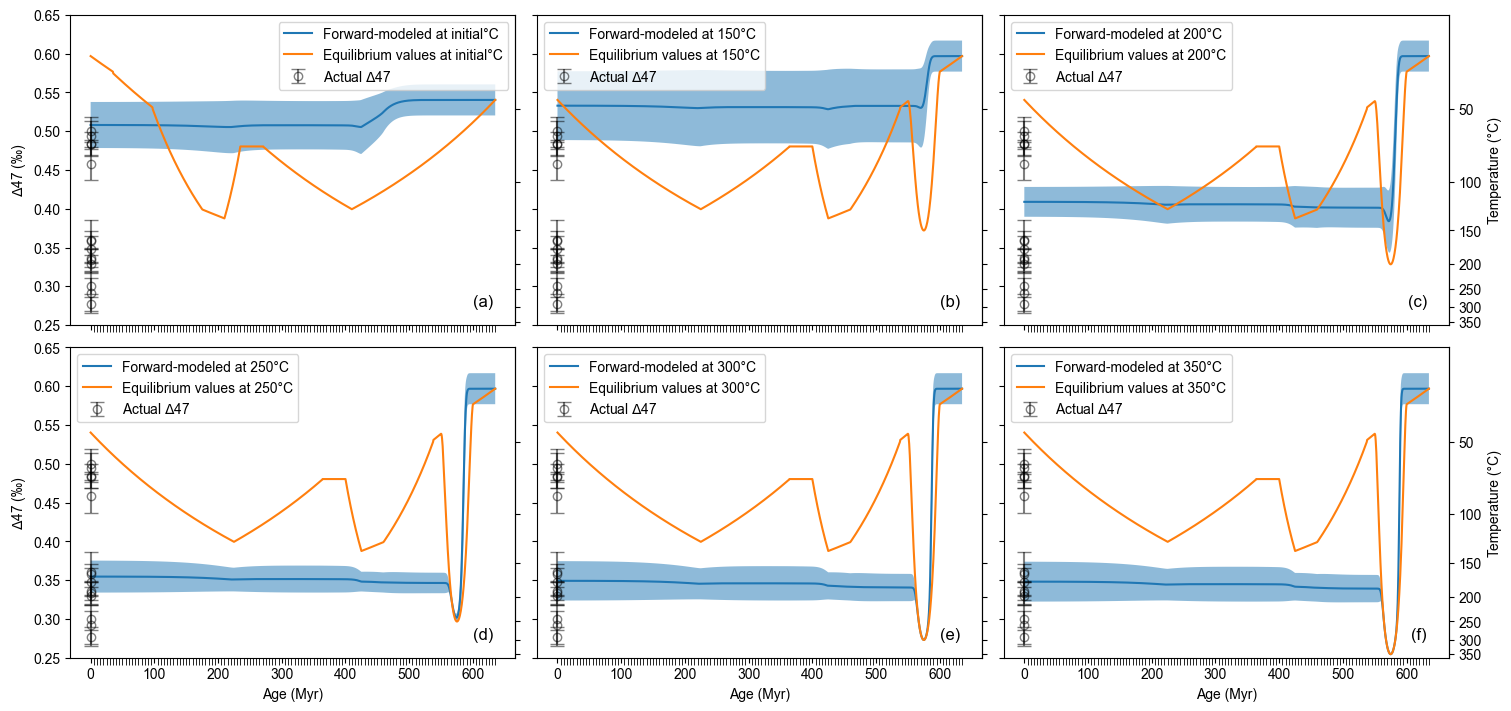

In [43]:
plt.rcParams["font.family"] = "Arial"  # 设置全局字体为 Arial

# =========================
# 全局：主y轴范围（Δ47）
# =========================
ymin, ymax = 0.15, 0.68

# =========================
# 预先计算：右侧温度轴的 tick 位置（一次算好，所有子图复用）
# =========================
d47_map = np.linspace(ymin, ymax, 600)
T_map = np.array([ipl.T_from_Deq(d) - 273.15 for d in d47_map], dtype=float)  # °C

mask = np.isfinite(T_map)
d47_map = d47_map[mask]
T_map = T_map[mask]

Tmin, Tmax = float(np.min(T_map)), float(np.max(T_map))

tick_step = 50  # 每隔 10°C 一个刻度（你原来就是这个）
tick_start = np.floor(Tmin / tick_step) * tick_step
tick_end   = np.ceil(Tmax / tick_step) * tick_step
T_ticks = np.arange(tick_start, tick_end + 0.1, tick_step)

# 每个温度刻度找到最接近的 Δ47 位置
pairs = []
for T in T_ticks:
    idx = int(np.abs(T_map - T).argmin())
    pairs.append((float(d47_map[idx]), int(round(T))))

# 去重（可能会出现多个温度映射到同一个Δ47点），并按Δ47从小到大排序
tmp = {}
for d, T in pairs:
    tmp[d] = T
pairs_sorted = sorted(tmp.items(), key=lambda x: x[0])

d47_ticks = [d for d, T in pairs_sorted]
T_labels  = [f"{T}" for d, T in pairs_sorted]

# =========================
# 作图
# =========================
fig, axes = plt.subplots(
    2, 3, figsize=(15, 7),
    sharex=True, sharey=True,
    constrained_layout=True
)

temperatures = ['initial', 150, 200, 250, 300, 350]
data = [
    (D_ini, Dstd_ini, Deq_ini),
    (D_150, Dstd_150, Deq_150),
    (D_200, Dstd_200, Deq_200),
    (D_250, Dstd_250, Deq_250),
    (D_300, Dstd_300, Deq_300),
    (D_350, Dstd_350, Deq_350)
]

for i, (temp, ax, (D, Dstd, Deq)) in enumerate(zip(temperatures, axes.flatten(), data)):
    ax.plot(tmyr, D, label=f'Forward-modeled at {temp}°C')
    ax.fill_between(tmyr, D - Dstd, D + Dstd, alpha=0.5)
    ax.plot(tmyr, Deq[::-1], label=f'Equilibrium values at {temp}°C')

    ax.errorbar(
        [0] * len(delta47),
        delta47, yerr=delta47_err,
        fmt='o',
        label='Actual $\Delta$47',
        color='black',
        capsize=5,
        alpha=0.5,
        markerfacecolor='none'
    )

    ax.set_ylim(ymin, ymax)

    if i >= 3:
        ax.set_xlabel('Age (Myr)')
    if i % 3 == 0:
        ax.set_ylabel('$\Delta$47 (‰)')

    # ========== 右侧 secondary y-axis：Temperature ==========
    secax = ax.secondary_yaxis('right')
    secax.set_yticks(d47_ticks)

    if i % 3 == 2:  # 仅每行最右侧显示数字
        secax.set_yticklabels(T_labels)
        secax.set_ylabel('Temperature (°C)')
    else:
        secax.tick_params(labelright=False)  # 不显示数字（保留刻度线）

    # ========== minor ticks（只画短刻度线，不显示数字） ==========
    ax.set_xticks(np.arange(0, np.max(tmyr) + 1, 5), minor=True)
    ax.set_yticks(np.arange(ymin, ymax + 1e-9, 0.05), minor=True)
    ax.tick_params(axis='x', which='minor', length=5)
    ax.tick_params(axis='y', which='minor', length=5)
    ax.set_ylim(0.25, 0.65)

    # 子图标签
    ax.text(
        0.95, 0.05, f'({chr(97 + i)})',
        transform=ax.transAxes,
        fontsize=12,
        va='bottom', ha='right'
    )

    ax.legend(loc='best')

# 保存
try:
    fig.savefig("output_figure_hu.svg", format="svg")
    fig.savefig("output_figure_hu.pdf", format="pdf")
except Exception as e:
    print(f"Error in saving figures: {e}")

plt.show()